Overview of the Approach:

*   Autoencoders: We'll use autoencoders for dimensionality reduction and learning latent features that best represent each customer. Autoencoders are neural networks trained to encode the input into a compressed representation (latent space) and then decode it back into the original input.
*   Clustering (KMeans): Once we have a reduced representation of each customer (through autoencoders), we’ll apply KMeans clustering to group similar customers together. Each customer will belong to a cluster, and customers in the same cluster will be more similar to each other.
Recommendation: For a given customer, we'll recommend the top 3 most similar customers from the same cluster based on their latent representations.



In [ ]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge Transactions with Products to get product category info
transactions_df = pd.merge(transactions_df, products_df[['ProductID', 'Category']], on='ProductID', how='left')

# Aggregate customer transaction data
customer_transactions = transactions_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    most_frequent_category=('Category', lambda x: x.mode()[0])
).reset_index()

# Merge customer profile data with aggregated transaction data
customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')

# Display the combined dataset
print(customer_data.head())


  CustomerID        CustomerName         Region  SignupDate  total_spend  \
0      C0001    Lawrence Carroll  South America  2022-07-10      3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13      1862.74   
2      C0003      Michael Rivera  South America  2024-03-07      2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09      5354.88   
4      C0005         Laura Weber           Asia  2022-08-15      2034.24   

   num_transactions most_frequent_category  
0               5.0            Electronics  
1               4.0               Clothing  
2               4.0             Home Decor  
3               8.0                  Books  
4               3.0            Electronics  


1.**Data Preprocessing**

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing pipeline to handle categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('region', OneHotEncoder(), ['Region']),
        ('category', OneHotEncoder(), ['most_frequent_category']),
        ('numeric', StandardScaler(), ['total_spend', 'num_transactions'])
    ])

# Apply preprocessing to the customer data (drop CustomerName as it's not useful for modeling)
X = preprocessor.fit_transform(customer_data.drop(columns=['CustomerName', 'CustomerID', 'SignupDate']))

# Display the transformed feature matrix shape
print(X.shape)


(200, 11)


**Data Preprocessing and Feature Engineering**


*   Before passing the data to the autoencoder model, we need to preprocess it by scaling numerical features and one-hot encoding categorical features.



**Key Changes**:

  Date Handling: We convert the SignupDate column to the number of days since the earliest signup date. This allows the autoencoder to use this as a numerical feature.

  Categorical Handling: The Region column is converted into one-hot encoded columns, which allows the clustering algorithm to use the region as a numerical feature.

  Data Imputation: Missing values are handled using SimpleImputer with the mean strategy. This applies to both the customer profile data and the latent features generated by the autoencoder.

  Feature Scaling: The features are scaled using StandardScaler to ensure they are on a similar scale before training the autoencoder.

**Troubleshooting**:

  Ensure that all columns fed into the model are numerical: If you still see errors related to non-numeric columns, print the data types using customer_data.dtypes to verify all columns are numerical or properly encoded.

  Watch for NaN values: If NaN values persist in the latent features, it could be a sign of exploding gradients or improper training. In such cases, experiment with smaller learning rates or regularization on the autoencoder.

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.3553 - val_loss: 1.3529
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.3529 - val_loss: 1.3504
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.3504 - val_loss: 1.3479
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.3479 - val_loss: 1.3454
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.3454 - val_loss: 1.3430
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.3430 - val_loss: 1.3405
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.3405 - val_loss: 1.3381
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.3381 - val_loss: 1.3357
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.3357 - val_loss: 1.3332
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.3332 - val_loss: 1.3308
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.3308 - val_loss: 1.3284
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.3284 - val_loss: 1.3260
E

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  CustomerID  Cluster
0      C0001        4
1      C0002        1
2      C0003        1
3      C0004        4
4      C0005        1


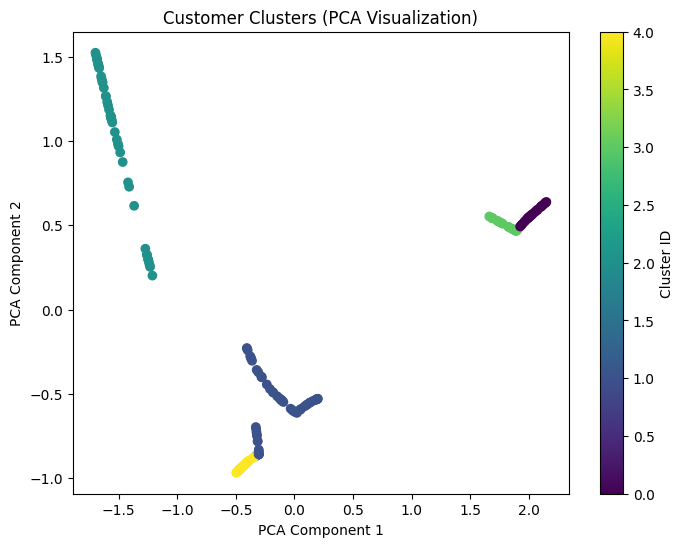

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

# Step 2: Load the customer and transaction data (replace this with the actual file loading)
# Assuming 'Customers.csv' and 'Transactions.csv' have already been loaded
customer_data = pd.read_csv('Customers.csv')
transaction_data = pd.read_csv('Transactions.csv')

# Step 3: Preprocess Data - Handle non-numeric columns

# Handle date columns (e.g., 'SignupDate') by converting to days since the earliest date
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
min_date = customer_data['SignupDate'].min()
customer_data['DaysSinceSignup'] = (customer_data['SignupDate'] - min_date).dt.days
customer_data.drop(columns=['SignupDate'], inplace=True)  # Drop the original date column

# Handle categorical columns (e.g., 'Region')
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Step 4: Handle other features (exclude CustomerID, CustomerName)
X = customer_data.drop(columns=['CustomerID', 'CustomerName'])

# Step 5: Handle missing values using SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 6: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 7: Build the Autoencoder Model
input_dim = X_scaled.shape[1]  # Number of features after scaling
encoding_dim = 10  # Latent space size (you can adjust this)

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)  # Regularizer added

# Decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Encoder model (for encoding the data into latent space)
encoder = Model(input_layer, encoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Step 8: Train the Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_data=(X_scaled, X_scaled))

# Step 9: Check the latent features (encoded_customers)
encoded_customers = encoder.predict(X_scaled)

# Step 10: Handle NaN values if they occur in the encoded features (due to issues in training)
if np.any(np.isnan(encoded_customers)):
    print("NaN values found in the latent features.")
    # Impute NaN values with mean
    imputer = SimpleImputer(strategy='mean')
    encoded_customers_imputed = imputer.fit_transform(encoded_customers)
else:
    encoded_customers_imputed = encoded_customers  # No imputation needed

# Step 11: Perform Clustering (KMeans) on the encoded features (latent space)
num_clusters = 5  # Number of clusters (this can be adjusted)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the KMeans clustering model
customer_data['Cluster'] = kmeans.fit_predict(encoded_customers_imputed)

# Step 12: Display the clusters for the first few customers
print(customer_data[['CustomerID', 'Cluster']].head())

# Step 13: Optional - Visualize the clusters (using 2D projection)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization (PCA)
pca = PCA(n_components=2)
encoded_customers_2d = pca.fit_transform(encoded_customers_imputed)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(encoded_customers_2d[:, 0], encoded_customers_2d[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster ID')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Clusters (PCA Visualization)')
plt.show()

# Optional: Save the clustering results
customer_data[['CustomerID', 'Cluster']].to_csv('clustered_customers.csv', index=False)


**Visualize the Clusters**:

we can visualize how the customers are grouped in the latent space. Since we’re using autoencoders to create the encoded features, i want to reduce the dimensions of these features to 2D (for easier visualization) using PCA or t-SNE.

PCA-based visualization:

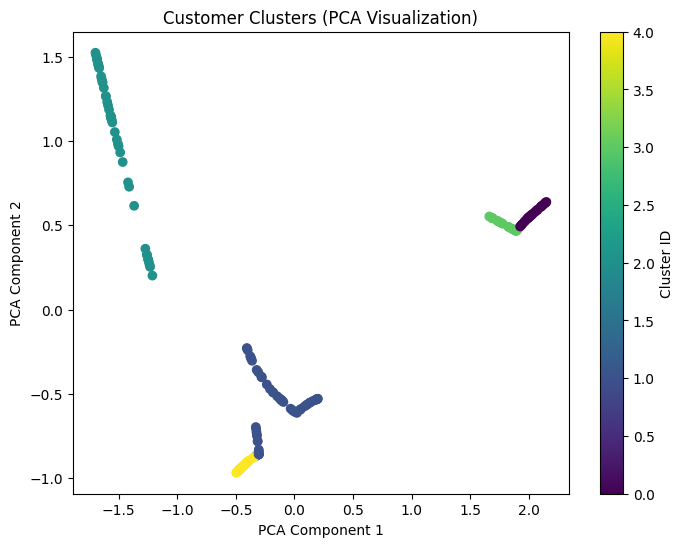

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
encoded_customers_2d = pca.fit_transform(encoded_customers_imputed)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(encoded_customers_2d[:, 0], encoded_customers_2d[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster ID')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Clusters (PCA Visualization)')
plt.show()



In [ ]:
# Count the number of customers in each cluster
cluster_sizes = customer_data['Cluster'].value_counts()
print(cluster_sizes)


Cluster
1    65
2    46
4    39
0    29
3    21
Name: count, dtype: int64


In [ ]:
# Get the centroids of each cluster (average of the encoded features)
cluster_centroids = kmeans.cluster_centers_
print("Cluster Centroids:\n", cluster_centroids)


Cluster Centroids:
 [[ 0.0000000e+00  1.2665521e+00  2.6104400e-01 -5.9604645e-08
   1.3724200e+00  1.6553361e+00  3.0160859e-02  5.9604645e-08
   1.2207551e+00 -1.1920929e-07]
 [ 8.6456537e-05  2.6345074e-02  2.3200420e-01  3.5155043e-02
   4.0101707e-03  2.2712429e-01  5.0220501e-01  1.0621594e-01
   2.3938517e-01  1.6114637e-01]
 [ 1.0264254e+00  8.9406967e-08 -2.9802322e-08  1.0879859e+00
   1.1920929e-07 -1.4901161e-07  1.2439494e-01  5.0435001e-01
  -1.1920929e-07  1.6368155e+00]
 [-1.4901161e-08  1.3933997e+00  5.5137807e-01  1.6562298e-01
   1.2586423e+00  1.4765737e+00  7.0787036e-01  2.9802322e-08
   7.2081804e-01 -2.9802322e-08]
 [-1.4901161e-08  5.9604645e-08  1.8074752e-01 -8.9406967e-08
   8.9406967e-08 -1.4901161e-07  1.2051940e-02  9.0468764e-01
  -8.9406967e-08 -1.7881393e-07]]


In [ ]:
# For example, show customers in Cluster 1
cluster_1_customers = customer_data[customer_data['Cluster'] == 1]
print(cluster_1_customers.head())


  CustomerID     CustomerName  DaysSinceSignup  Region_Europe  \
1      C0002   Elizabeth Lutz               22          False   
2      C0003   Michael Rivera              775          False   
4      C0005      Laura Weber              205          False   
5      C0006  Brittany Palmer              715          False   
6      C0007      Paul Graves              147          False   

   Region_North America  Region_South America  Cluster  
1                 False                 False        1  
2                 False                  True        1  
4                 False                 False        1  
5                 False                  True        1  
6                 False                 False        1  


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
sil_score = silhouette_score(encoded_customers_imputed, customer_data['Cluster'])
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.5767267346382141


In [ ]:
# Calculate Inertia (Sum of squared distances from points to cluster centers)
inertia = kmeans.inertia_
print(f"KMeans Inertia: {inertia}")


KMeans Inertia: 45.730045318603516


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a dictionary to store lookalikes for each customer
lookalikes = {}

# Loop through each customer to find the top 3 similar lookalikes in the same cluster
for i, row in customer_data.iterrows():
    customer_id = row['CustomerID']
    cluster = row['Cluster']

    # Find all customers in the same cluster
    cluster_customers = customer_data[customer_data['Cluster'] == cluster]

    # Get the encoded features (latent representation) for the current customer
    customer_latent = encoded_customers[i].reshape(1, -1)

    # Compute cosine similarity between the current customer and all others in the same cluster
    similarities = cosine_similarity(customer_latent, encoded_customers[cluster_customers.index])[0]

    # Sort customers by similarity (excluding the customer itself)
    similar_indices = similarities.argsort()[-4:-1][::-1]  # Exclude self (index 0)

    # Get the most similar customers and their similarity scores
    similar_customers = [
        (cluster_customers.iloc[idx]['CustomerID'], similarities[idx])
        for idx in similar_indices
    ]

    # Store the results in a dictionary
    lookalikes[customer_id] = similar_customers

# Display the lookalikes for the first customer
print(lookalikes[customer_data.iloc[0]['CustomerID']])


[('C0112', 0.99999815), ('C0025', 0.99999285), ('C0071', 0.99998397)]


In [ ]:
# Prepare the results in the required format
lookalike_data = []
for customer_id, similar_customers in lookalikes.items():
    for similar_customer, score in similar_customers:
        lookalike_data.append([customer_id, similar_customer, score])

# Convert the list to a DataFrame
lookalike_df = pd.DataFrame(lookalike_data, columns=['cust_id', 'lookalike_cust_id', 'similarity_score'])

# Save the results to a CSV file
lookalike_df.to_csv('Lookalike.csv', index=False)

print("Lookalike.csv file has been saved.")


Lookalike.csv file has been saved.
